In [67]:
!pip install impyute

# Data Preprocessing

In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, make_scorer
from scipy import stats
from scipy.stats import skew, norm
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from impyute.imputation.cs import mice

import warnings
def ignore_warn(*args, **kwargs): pass
warnings.warn = ignore_warn

%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

sns.set_style("whitegrid")

In [69]:
#import data
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
print("train: " + str(train.shape))
print("test: " + str(test.shape))
print(train.columns)

train: (1460, 81)
test: (1459, 80)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual

In [70]:
#중복확인
idsUnique = len(set(train.Id)) #중복되지 않는 원소
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

#id 제거
Id_test = test.Id #제출시 필요하므로 keep
train.drop("Id", axis=1, inplace = True)
test.drop("Id", axis=1, inplace = True)

There are 0 duplicate IDs for 1460 total entries


### Preprocessing

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

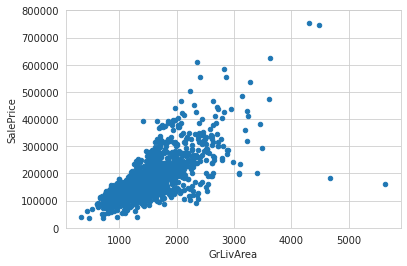

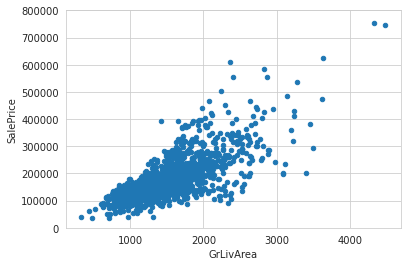

In [71]:
#GrLivArea / SalePrice간 scatter plot 확인
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

#outlier 제거
train = train[(train.GrLivArea < 4000) | (train.SalePrice > 700000)]
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

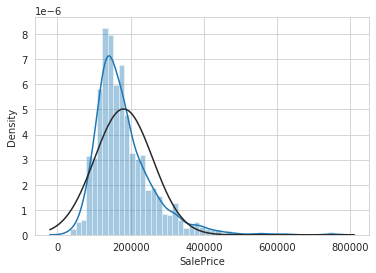

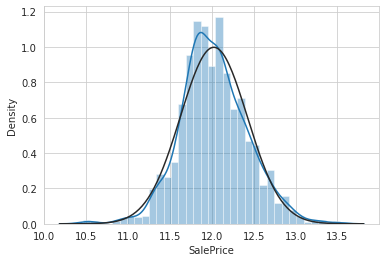

<Figure size 432x288 with 0 Axes>

In [72]:
#Log transform
sns.distplot(train['SalePrice'], fit=norm)
fig = plt.figure()
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

sns.distplot(train['SalePrice'], fit=norm)
fig = plt.figure()

In [73]:
print(test.shape)
print(train.shape)

(1459, 79)
(1458, 80)


In [74]:
#missing data check
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data.Total > 0].head(-1)

,Total,Percent
PoolQC,1452,0.996
MiscFeature,1404,0.963
Alley,1367,0.938
Fence,1177,0.807
FireplaceQu,690,0.473
LotFrontage,259,0.178
GarageYrBlt,81,0.056
GarageCond,81,0.056
GarageType,81,0.056
GarageFinish,81,0.056


In [75]:
#fill null data
def replace_na(df):
    #Alley: data description says NA means "no alley access"
    df.loc[:, "Alley"] = df.loc[:, "Alley"].fillna("None")
    #BedroomAbvGr: NA most likely means 0
    df.loc[:, "BedroomAbvGr"] = df.loc[:, "BedroomAbvGr"].fillna(0)
    #BsmtQual etc: data description says NA for basement feature is "no basement"
    df.loc[:, "BsmtQual"] = df.loc[:, "BsmtQual"].fillna("No")
    df.loc[:, "BsmtCond"] = df.loc[:, "BsmtCond"].fillna("No")
    df.loc[:, "BsmtExposure"] = df.loc[:, "BsmtExposure"].fillna("No")
    df.loc[:, "BsmtFinType1"] = df.loc[:, "BsmtFinType1"].fillna("No")
    df.loc[:, "BsmtFinType2"] = df.loc[:, "BsmtFinType2"].fillna("No")
    df.loc[:, "BsmtFullBath"] = df.loc[:, "BsmtFullBath"].fillna(0)
    df.loc[:, "BsmtHalfBath"] = df.loc[:, "BsmtHalfBath"].fillna(0)
    df.loc[:, "BsmtUnfSF"] = df.loc[:, "BsmtUnfSF"].fillna(0)
    #CentralAir: NA most likely means No
    df.loc[:, "CentralAir"] = df.loc[:, "CentralAir"].fillna("N")
    #Condition: NA most likely means Normal
    df.loc[:, "Condition1"] = df.loc[:, "Condition1"].fillna("Norm")
    df.loc[:, "Condition2"] = df.loc[:, "Condition2"].fillna("Norm")
    #EnclosedPorch: NA most likely means no enclosed porch
    df.loc[:, "EnclosedPorch"] = df.loc[:, "EnclosedPorch"].fillna(0)
    #External stuff: NA most likely means average
    df.loc[:, "ExterCond"] = df.loc[:, "ExterCond"].fillna("TA")
    df.loc[:, "ExterQual"] = df.loc[:, "ExterQual"].fillna("TA")
    #Fence: data description says NA means "no fence"
    df.loc[:, "Fence"] = df.loc[:, "Fence"].fillna("No")
    #FireplaceQu: data description says NA means "no fireplace"
    df.loc[:, "FireplaceQu"] = df.loc[:, "FireplaceQu"].fillna("No")
    df.loc[:, "Fireplaces"] = df.loc[:, "Fireplaces"].fillna(0)
    #Functional: data description says NA means Typical
    df.loc[:, "fuctional"] = df.loc[:, "Functional"].fillna("Typ")
    #GarageType etc: data description says NA for garage features is "no garage"
    df.loc[:, "GarageType"] = df.loc[:, "GarageType"].fillna("No")
    df.loc[:, "GarageFinish"] = df.loc[:, "GarageFinish"].fillna("No")
    df.loc[:, "GarageQual"] = df.loc[:, "GarageQual"].fillna("No")
    df.loc[:, "GarageCond"] = df.loc[:, "GarageCond"].fillna("No")
    df.loc[:, "GarageArea"] = df.loc[:, "GarageArea"].fillna(0)
    df.loc[:, "GarageCars"] = df.loc[:, "GarageCars"].fillna(0)
    #HalfBath: NA most likely means no half baths above grade
    df.loc[:, "HalfBath"] = df.loc[:, "HalfBath"].fillna(0)
    #HeatingQC: NA most likely means typical
    df.loc[:, "HeatingQC"] = df.loc[:, "HeatingQC"].fillna("TA")
    #kitchenAbvGr: NA most likely means 0
    df.loc[:, "KitchenAbvGr"] = df.loc[:, "KitchenAbvGr"].fillna(0)
    #KitchenQual: NA most likely means typical
    df.loc[:, "KitchenQual"] = df.loc[:, "KitchenQual"].fillna("TA")
    #LotFrontage: NA most likely means no lot frontage
    df.loc[:, "LotFrontage"] = df.loc[:, "LotFrontage"].fillna(0)
    #LotShpae: NA most likely means regular
    df.loc[:, "LotShape"] = df.loc[:, "LotShape"].fillna("Reg")
    #MasVnrType : NA most likely means no veneer
    df.loc[:, "MasVnrType"] = df.loc[:, "MasVnrType"].fillna("None")
    df.loc[:, "MasVnrArea"] = df.loc[:, "MasVnrArea"].fillna(0)
    #MiscFeature : data description says NA means "no misc feature"
    df.loc[:, "MiscFeature"] = df.loc[:, "MiscFeature"].fillna("No")
    df.loc[:, "MiscVal"] = df.loc[:, "MiscVal"].fillna(0)
    #OpenPorchSF : NA most likely means no open porch
    df.loc[:, "OpenPorchSF"] = df.loc[:, "OpenPorchSF"].fillna(0)
    #PavedDrive : NA most likely means not paved
    df.loc[:, "PavedDrive"] = df.loc[:, "PavedDrive"].fillna("N")
    #PoolQC : data description says NA means "no pool"
    df.loc[:, "PoolQC"] = df.loc[:, "PoolQC"].fillna("No")
    df.loc[:, "PoolArea"] = df.loc[:, "PoolArea"].fillna(0)
    #SaleCondition : NA most likely means normal sale
    df.loc[:, "SaleCondition"] = df.loc[:, "SaleCondition"].fillna("Normal")
    #ScreenPorch : NA most likely means no screen porch
    df.loc[:, "ScreenPorch"] = df.loc[:, "ScreenPorch"].fillna(0)
    # TotRmsAbvGrd : NA most likely means 0
    df.loc[:, "TotRmsAbvGrd"] = df.loc[:, "TotRmsAbvGrd"].fillna(0)
    #Utilities : NA most likely means all public utilities
    df.loc[:, "Utilities"] = df.loc[:, "Utilities"].fillna("AllPub")
    #WoodDeckSF : NA most likely means no wood deck
    df.loc[:, "WoodDeckSF"] = df.loc[:, "WoodDeckSF"].fillna(0)
    return df

train = replace_na(train)
test = replace_na(test)

In [76]:
def cat_to_num(df):
    #카테고리형 => 숫자형
    df = df.replace({"MSSubClass": {20: "SC20", 30: "SC30", 40: "SC40", 45: "SC45",
                                   50: "SC50", 60: "SC60", 70: "SC70", 75: "SC75",
                                   80: "SC80", 85: "SC85", 90: "SC90", 120: "SC120",
                                   150: "SC150", 160: "SC160", 180: "SC180", 190: "SC190"},
                    "MoSold": {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                              7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
                    })
    df = df.replace({"Alley": {"Grvl": 1, "Pave": 2},
                    "BsmtCond": {"No": 0, "Po": 1, "Fa":2, "TA": 3, "Gd": 4, "Ex": 5}, 
                     "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                     "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                     "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                       "ALQ" : 5, "GLQ" : 6},
                     "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                     "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                     "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                     "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                     "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                     "Min2" : 6, "Min1" : 7, "Typ" : 8},
                     "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                     "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                     "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                     "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                     "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                     "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                     "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                     "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                     "Street" : {"Grvl" : 1, "Pave" : 2},
                     "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}})
    return df

train = cat_to_num(train)
test = cat_to_num(test)

In [77]:
def make_has_feature(df):
    df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x>0 else 0)
    df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x>0 else 0)
    df['hasgarage'] = df['GarageArea'].apply(lambda x:1 if x>0 else 0)
    df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x:1 if x>0 else 0)
    df['hasfireplace'] = df['Fireplaces'].apply(lambda x:1 if x>0 else 0)
    return df

train = make_has_feature(train)
test = make_has_feature(test)

In [78]:
numerical_features = train.select_dtypes(exclude = ['object']).columns
skew_features = train[numerical_features].apply(lambda x: skew(x)).sort_values(ascending=True)
print(skew_features.head())
corr_features = train.corr().SalePrice
skew_corr_features = skew_features.to_frame().join(corr_features)
skew_corr_features.columns = ['skew', 'corr']
print(skew_corr_features[(skew_corr_features['corr']<0.05) & (abs(skew_corr_features['skew'])>5)])

Utilities    -38.144
Street       -15.492
hasbsmt      -6.036 
Functional   -4.903 
LandSlope    -4.805 
dtype: float64
                skew   corr
Utilities    -38.144 0.013 
LowQualFinSF 8.996   -0.038
MiscVal      24.435  -0.020


In [79]:
print(train['Utilities'])
train.groupby('Utilities').count()['SalePrice']
train = train.drop(columns=['Utilities'])
test = test.drop(columns=['Utilities'])

0       4
1       4
2       4
3       4
4       4
       ..
1455    4
1456    4
1457    4
1458    4
1459    4
Name: Utilities, Length: 1458, dtype: int64


In [80]:
print(train.groupby('MiscVal').count()['SalePrice'])
print(train.groupby('LowQualFinSF').count()['SalePrice'])

MiscVal
0        1406
54       1   
350      1   
400      11  
450      4   
480      2   
500      8   
560      1   
600      4   
620      1   
700      5   
800      1   
1150     1   
1200     2   
1300     1   
1400     1   
2000     4   
2500     1   
3500     1   
8300     1   
15500    1   
Name: SalePrice, dtype: int64
LowQualFinSF
0      1432
53     1   
80     3   
120    1   
144    1   
156    1   
205    1   
232    1   
234    1   
360    2   
371    1   
384    1   
390    1   
392    1   
397    1   
420    1   
473    1   
479    1   
481    1   
513    1   
514    1   
515    1   
528    1   
572    1   
Name: SalePrice, dtype: int64


In [81]:
def simplify_feature(df) :
    # 1. 이미 있는 feature를 단순화시키기
    df["SimplOverallQual"] = df.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                    4 : 2, 5 : 2, 6 : 2, # average
                                                    7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                    })
    df["SimplOverallCond"] = df.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                    4 : 2, 5 : 2, 6 : 2, # average
                                                    7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                    })
    df["SimplPoolQC"] = df.PoolQC.replace({1 : 1, 2 : 1, # average
                                            3 : 2, 4 : 2 # good
                                            })
    df["SimplGarageCond"] = df.GarageCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                        })
    df["SimplGarageQual"] = df.GarageQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                        })
    df["SimplFireplaceQu"] = df.FireplaceQu.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                          })
    df["SimplFireplaceQu"] = df.FireplaceQu.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                          })
    df["SimplFunctional"] = df.Functional.replace({1 : 1, 2 : 1, # bad
                                                   3 : 2, 4 : 2, # major
                                                   5 : 3, 6 : 3, 7 : 3, # minor
                                                   8 : 4 # typical
                                                        })
    df["SimplKitchenQual"] = df.KitchenQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                          })
    df["SimplHeatingQC"] = df.HeatingQC.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                      })
    df["SimplBsmtFinType1"] = df.BsmtFinType1.replace({1 : 1, # unfinished
                                                       2 : 1, 3 : 1, # rec room
                                                       4 : 2, 5 : 2, 6 : 2 # living quarters
                                                       })
    df["SimplBsmtFinType2"] = df.BsmtFinType2.replace({1 : 1, # unfinished
                                                       2 : 1, 3 : 1, # rec room
                                                       4 : 2, 5 : 2, 6 : 2 # living quarters
                                                       })
    df["SimplBsmtCond"] = df.BsmtCond.replace({1 : 1, # bad
                                               2 : 1, 3 : 1, # average
                                               4 : 2, 5 : 2 # good
                                               })
    df["SimplBsmtQual"] = df.BsmtQual.replace({1 : 1, # bad
                                               2 : 1, 3 : 1, # average
                                               4 : 2, 5 : 2 # good
                                               })
    df["SimplExterCond"] = df.ExterCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                 })
    df["SimplExterQual"] = df.ExterQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
    return df

def combine_feature(df) :
    # 2* 기존 feature들을 조합시키기
    # Overall quality of the house
    df["OverallGrade"] = df["OverallQual"] * df["OverallCond"]
    # Overall quality of the garage
    df["GarageGrade"] = df["GarageQual"] * df["GarageCond"]
    # Overall quality of the exterior
    df["ExterGrade"] = df["ExterQual"] * df["ExterCond"]
    # Overall kitchen score
    df["KitchenScore"] = df["KitchenAbvGr"] * df["KitchenQual"]
    # Overall fireplace score
    df["FireplaceScore"] = df["Fireplaces"] * df["FireplaceQu"]
    # Overall garage score
    df["GarageScore"] = df["GarageArea"] * df["GarageQual"]
    # Overall pool score
    df["PoolScore"] = df["PoolArea"] * df["PoolQC"]
    # Simplified overall quality of the house
    df["SimplOverallGrade"] = df["SimplOverallQual"] * df["SimplOverallCond"]
    # Simplified overall quality of the exterior
    df["SimplExterGrade"] = df["SimplExterQual"] * df["SimplExterCond"]
    # Simplified overall pool score
    df["SimplPoolScore"] = df["PoolArea"] * df["SimplPoolQC"]
    # Simplified overall garage score
    df["SimplGarageScore"] = df["GarageArea"] * df["SimplGarageQual"]
    # Simplified overall fireplace score
    df["SimplFireplaceScore"] = df["Fireplaces"] * df["SimplFireplaceQu"]
    # Simplified overall kitchen score
    df["SimplKitchenScore"] = df["KitchenAbvGr"] * df["SimplKitchenQual"]
    # Total number of bathrooms
    df["TotalBath"] = df["BsmtFullBath"] + (0.5 * df["BsmtHalfBath"]) + \
    df["FullBath"] + (0.5 * df["HalfBath"])
    # Total SF for house (incl. basement)
    df["AllSF"] = df["GrLivArea"] + df["TotalBsmtSF"]
    # Total SF for 1st + 2nd floors
    df["AllFlrsSF"] = df["1stFlrSF"] + df["2ndFlrSF"]
    # Total SF for porch
    df["AllPorchSF"] = df["OpenPorchSF"] + df["EnclosedPorch"] + \
    df["3SsnPorch"] + df["ScreenPorch"]
    # Has masonry veneer or not
    df["HasMasVnr"] = df.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1,  "Stone" : 1, "None" : 0})
    # House completed before sale or not
    df["BoughtOffPlan"] = df.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
    
    return df

train = simplify_feature(train)
test = simplify_feature(test)

In [82]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))

train_num = train[numerical_features]
train_cat = train[categorical_features]
test_num = test[numerical_features]
test_cat = test[categorical_features]

Numerical features : 72
Categorical features : 27


In [83]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice           1.000 
OverallQual         0.821 
GrLivArea           0.725 
SimplOverallQual    0.707 
ExterQual           0.682 
GarageCars          0.681 
KitchenQual         0.670 
GarageArea          0.656 
TotalBsmtSF         0.648 
SimplExterQual      0.635 
1stFlrSF            0.621 
BsmtQual            0.617 
SimplKitchenQual    0.609 
FullBath            0.596 
SimplBsmtQual       0.592 
YearBuilt           0.587 
YearRemodAdd        0.566 
FireplaceQu         0.547 
GarageYrBlt         0.542 
TotRmsAbvGrd        0.538 
SimplFireplaceQu    0.514 
hasfireplace        0.510 
Fireplaces          0.492 
HeatingQC           0.474 
MasVnrArea          0.431 
SimplHeatingQC      0.397 
BsmtFinSF1          0.392 
GarageQual          0.363 
GarageCond          0.357 
BsmtExposure        0.338 
BsmtFinType1        0.335 
WoodDeckSF          0.334 
OpenPorchSF         0.325 
hasgarage           0.323 
2ndFlrSF            0.320 
HalfBat

In [84]:
list_high_corr = list(corr[corr['SalePrice'] > 0.5][['SalePrice']].index.values)
list_high_corr.remove('SalePrice')
print(list_high_corr)

['OverallQual', 'GrLivArea', 'SimplOverallQual', 'ExterQual', 'GarageCars', 'KitchenQual', 'GarageArea', 'TotalBsmtSF', 'SimplExterQual', '1stFlrSF', 'BsmtQual', 'SimplKitchenQual', 'FullBath', 'SimplBsmtQual', 'YearBuilt', 'YearRemodAdd', 'FireplaceQu', 'GarageYrBlt', 'TotRmsAbvGrd', 'SimplFireplaceQu', 'hasfireplace']


In [102]:
def polynomial_feature(df) :
    for colname in numerical_features :
        if colname not in numerical_features: continue
        train[colname + "-s2"] = train[colname] ** 2
        train[colname + "-s3"] = train[colname] ** 3
        train[colname + "-s4"] = train[colname] ** 4
        train[colname + "-Sq"] = np.sqrt(train[colname])

        li_colnames = []
        li_colnames.append(colname)
        li_colnames.append(colname + "-s2")
        li_colnames.append(colname + "-s3")
        li_colnames.append(colname + "-s4")
        li_colnames.append(colname + "-Sq")
        c = train[["SalePrice"] + li_colnames].corr()
        c.sort_values(["SalePrice"], ascending = False, inplace = True)
        li_colnames.remove(c["SalePrice"].head().index[1])
        train.drop(columns=li_colnames)
    return df

train_num = polynomial_feature(train_num)
test_num = polynomial_feature(test_num)

In [103]:
# skew가 0,5보다 크거나 -0.5보다 작은것에 한하여 로그 변환을 해준다.
# 보통 0.5보다 크면 skew가 어느정도 존재한다고 판단하여 변환시켜준다.
positive_skewed_features = []
negavtive_skewed_features = []
def log_transforam(df_train, df_test) :
    for colname in train_num.columns :
        if "-" in colname : continue
            
        if df_train[colname].skew() > 0.5 :
            min_val = min(df_train[colname].min(), df_test[colname].min())
            positive_skewed_features.append([colname, min_val])
            df_train[colname + '-log'] = np.log1p(df_train[colname] - min_val)
            df_test[colname + '-log'] = np.log1p(df_test[colname] - min_val)
            
        elif df_train[colname].skew() < -0.5 and colname != 'GarageQual':
            max_val = max(df_train[colname].max(), df_test[colname].max())
            negavtive_skewed_features.append([colname, max_val])
            df_train[colname + '-log'] = np.log1p( + max_val - df_train[colname])
            df_test[colname + '-log'] = np.log1p( + max_val - df_test[colname])
    
    return df_train, df_test

train_num, test_num = log_transforam(train_num, test_num)

In [104]:
# 숫자형 feature를 추가 생성하면서 나온 NA값을 역추산해준다.
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

imputer = KNNImputer(n_neighbors=5).fit(train_num.values)

np_train_imputed = imputer.transform(train_num)
train_num_imputed = pd.DataFrame(np_train_imputed, columns = train_num.columns, index=train_num.index)
np_test_imputed = imputer.transform(test_num)
test_num_imputed = pd.DataFrame(np_test_imputed, columns = test_num.columns, index=test_num.index)

print("Remaining NAs for numerical features in train : " + str(train_num_imputed.isnull().values.sum()))
train_num = train_num_imputed
test_num = test_num_imputed

NAs for numerical features in train : 0
Remaining NAs for numerical features in train : 0


In [105]:
# 범주형 feature를 onehot 인코딩 시킨다. 이 과정에서 null 값도 없어진다.
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat_num = len(train_cat)
dataset = pd.concat(objs=[train_cat, test_cat], axis=0)
dataset_preprocessed = pd.get_dummies(dataset)
train_cat = dataset_preprocessed[:train_cat_num]
test_cat = dataset_preprocessed[train_cat_num:]
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))

NAs for categorical features in train : 0
Remaining NAs for categorical features in train : 0


In [106]:
# 범주형과 숫자형 feature들을 합쳐준다.
X_train = pd.concat([train_num, train_cat], axis = 1)
X_test = pd.concat([test_num, test_cat], axis = 1)
y_train = y
Id_test
print("New number of features : " + str(X_train.shape[1]))

New number of features : 337


In [107]:
#이후 사용을 위해 저장
X_train.to_csv("/kaggle/working/X_train.csv")
X_test.to_csv("/kaggle/working/X_test.csv")
y_train.to_csv("/kaggle/working/y_train.csv")
Id_test.to_csv("/kaggle/working/Id_train.csv")